# 🚙 beyond_AVR demo
> Vehicle damage detection using CNN
##### Hanyang univ. department of CSe<br/>2016003418 김인제  <br/>2016003390 김예진

## 🏁 Initial setup
> May take few minutes

In [ ]:
#@markdown google drive

from google.colab import drive, files
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
#@markdown library

# install effnet
!pip install -U git+https://github.com/qubvel/efficientnet

# select tf version
%tensorflow_version 1.x

# import library
!rm -rf /tmp/beyond_AVR_demo
%cd /tmp
!git clone https://github.com/injekim/beyond_AVR_demo.git
%cd /tmp/beyond_AVR_demo

from dic import *
from func import *

# !nvidia-smi

  Cloning https://github.com/qubvel/efficientnet to /tmp/pip-req-build-fhy5j64s
  Running command git clone -q https://github.com/qubvel/efficientnet /tmp/pip-req-build-fhy5j64s
     |████████████████████████████████| 51kB 2.9MB/s 
  Created wheel for efficientnet: filename=efficientnet-1.1.1-cp37-none-any.whl size=18421 sha256=75ae11373c3067961cc48e4bf155e541b566046b92c66915a07c0ecc46e75478
  Stored in directory: /tmp/pip-ephem-wheel-cache-3i55f1af/wheels/64/60/2e/30ebaa76ed1626e86bfb0cc0579b737fdb7d9ff8cb9522663a
Successfully built efficientnet
TensorFlow 1.x selected.
/tmp
Cloning into 'beyond_AVR_demo'...
remote: Enumerating objects: 56, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 56 (delta 23), reused 31 (delta 1), pack-reused 0
Unpacking objects: 100% (56/56), done.
/tmp/beyond_AVR_demo


Using TensorFlow backend.


In [ ]:
#@markdown model

SUMMARY = False

#directories
BASE_PATH = "/gdrive/My Drive/Capstone/models_final"
DATA_PATH = "/tmp/data/"

PATH_ORIEN = os.path.join(BASE_PATH, "orien.h5")
PATH_DMG = os.path.join(BASE_PATH, "dmg.h5")

PATH_HYN = {
  "front": os.path.join(BASE_PATH, "hyn", "hyn_front.h5"),
  "side": os.path.join(BASE_PATH, "hyn", "hyn_side.h5"),
  "back": os.path.join(BASE_PATH, "hyn", "hyn_back.h5")
}

PATH_KIA = {
  "front": os.path.join(BASE_PATH, "kia", "kia_front.h5"),
  "side": os.path.join(BASE_PATH, "kia", "kia_side.h5"),
  "back": os.path.join(BASE_PATH, "kia", "kia_back.h5")
}

MODEL_ORIEN = load_model(PATH_ORIEN)
MODEL_ORIEN.load_weights(PATH_ORIEN)
if SUMMARY:
  MODEL_ORIEN.summary()

# progress bar setup
print("loading models... [" + " " * 16 + "]", end="", flush=True)

print("\b" * (17), end="")
print("{:17}".format("██" * 1) + "]", end="", flush=True)

MODEL_DMG = load_model(PATH_DMG)
MODEL_DMG.load_weights(PATH_DMG)
if SUMMARY:
  MODEL_DMG.summary()

print("\b" * (17), end="")
print("{:17}".format("██" * 2) + "]", end="", flush=True)

MODEL_KIA = {}
for i, k in enumerate(PATH_KIA.keys()):
  MODEL_KIA[k] = load_model(PATH_KIA[k])
  MODEL_KIA[k].load_weights(PATH_KIA[k])
  if SUMMARY:
    MODEL_KIA[k].summary()

  print("\b" * (17), end="")
  print("{:17}".format("██" * (3+i)) + "]", end="", flush=True)

MODEL_HYN = {}
for i, k in enumerate(PATH_HYN.keys()):
  MODEL_HYN[k] = load_model(PATH_HYN[k])
  MODEL_HYN[k].load_weights(PATH_HYN[k])
  if SUMMARY:
    MODEL_HYN[k].summary()

  print("\b" * (17), end="")
  print("{:17}".format("██" * (6+i)) + "]", end="", flush=True)

MODEL_VEH = {
    "kia": MODEL_KIA,
    "hyn": MODEL_HYN
}

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

loading models... [                ]██               ]████             ]██████           ]████████         ]██████████       ]████████████     ]██████████████   ]████████████████ ]

## 📊 Select dataset

In [ ]:
DATA_SET = "Use demo data" #@param ["Use demo data", "Upload image"]
DEMO = "damage_test.zip" #@param ["damage_test.zip", "model_test.zip", "model_and_damage_test.zip"]

!rm -rf /tmp/data
!mkdir /tmp/data
%cd /tmp/data

if DATA_SET == "Upload image":
  image = files.upload()
  while image:
    image = files.upload()
else:
  from zipfile import ZipFile
  print("[ downloading demo data ]")
  demosrc = "/gdrive/My Drive/Capstone/demo_data/" + DEMO
  with ZipFile(demosrc, 'r') as testzip:
    testzip.extractall('/tmp/data')

%cd /tmp/

/tmp/data
[ downloading demo data ]
/tmp


## ⚙️ Options

In [ ]:
#@markdown #### 🎲 Functions
DAMAGE_DETECTION = True #@param {type:"boolean"}
MODEL_DETECTION = False #@param {type:"boolean"}

#@markdown ---
#@markdown #### 🚙 Damage detection
#@markdown Patch
PATCH_SIZE = 200 #@param {type:"number"}
STEP_SIZE = 50 #@param {type:"number"}
SHOW_PROB = True #@param {type:"boolean"}
PATCH_OVERLAP = PATCH_SIZE - STEP_SIZE
#@markdown Threshold
DENT_THLD = 0.95 #@param {type:"number"}
SCRATCH_THLD = 0.75 #@param {type:"number"}

## 🎑 Detect

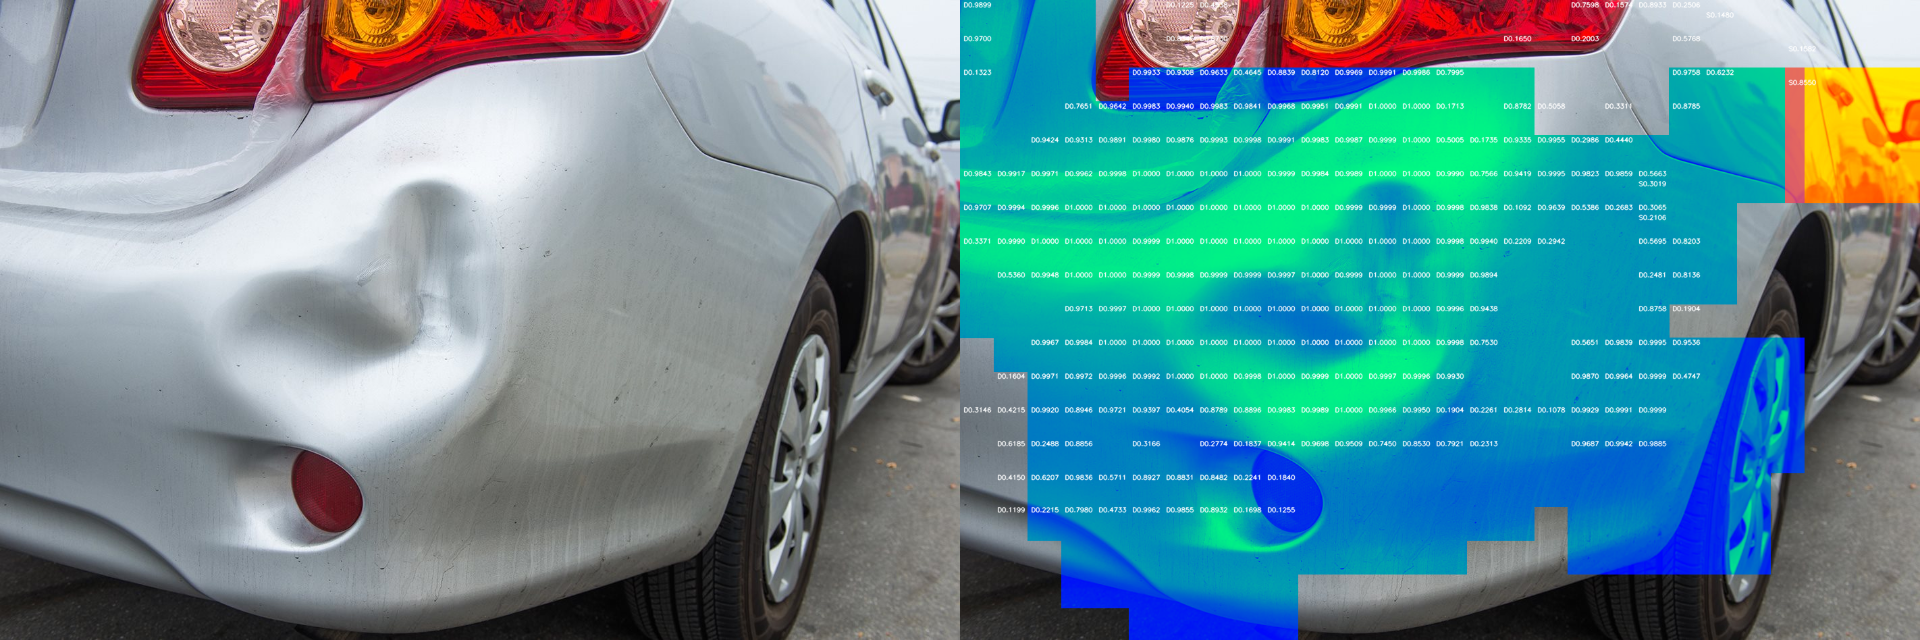

test_image_1.jpg


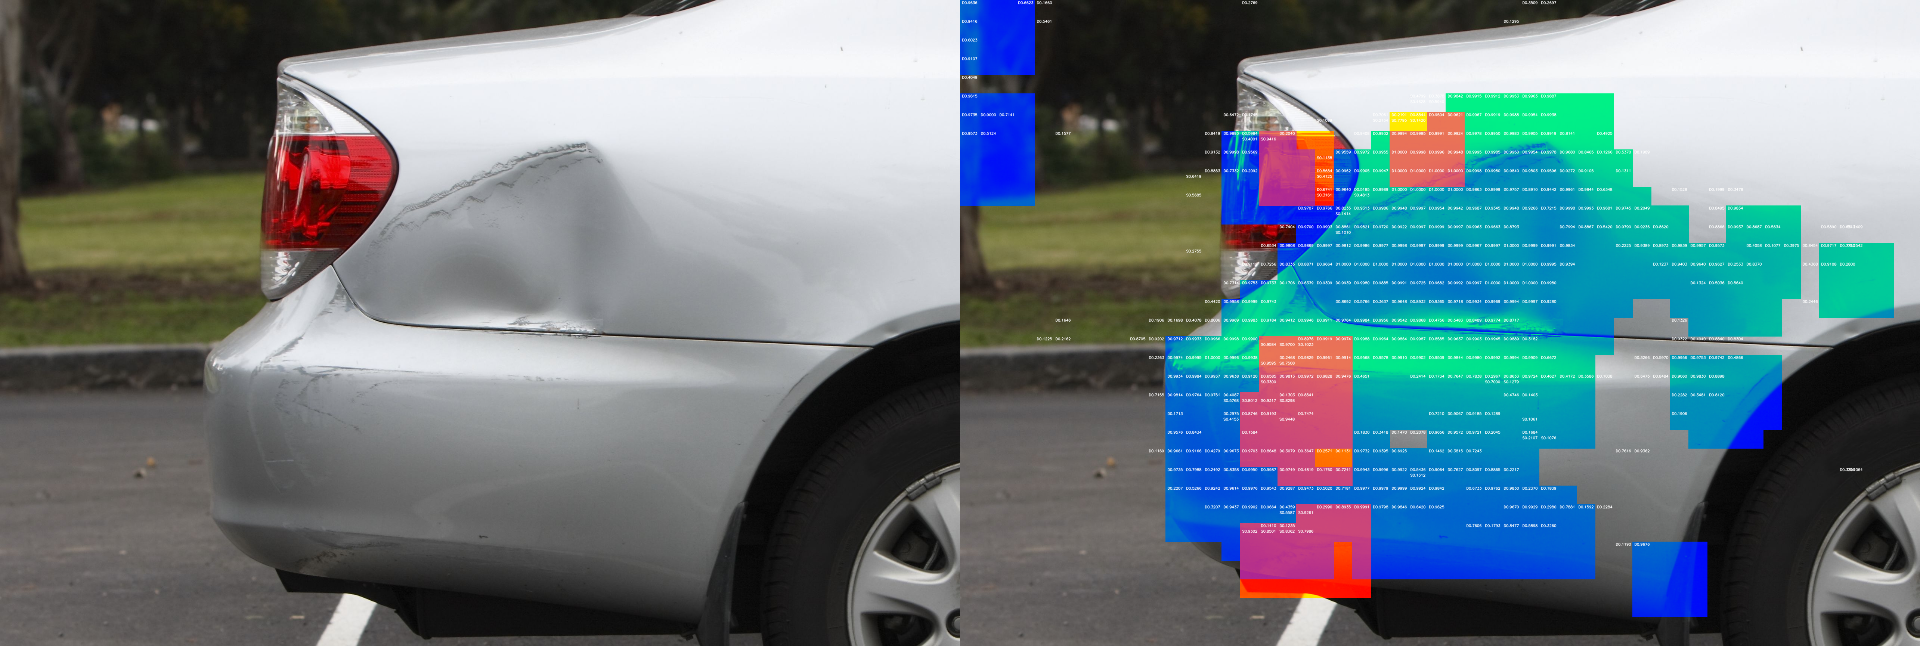

test_image_2.jpg


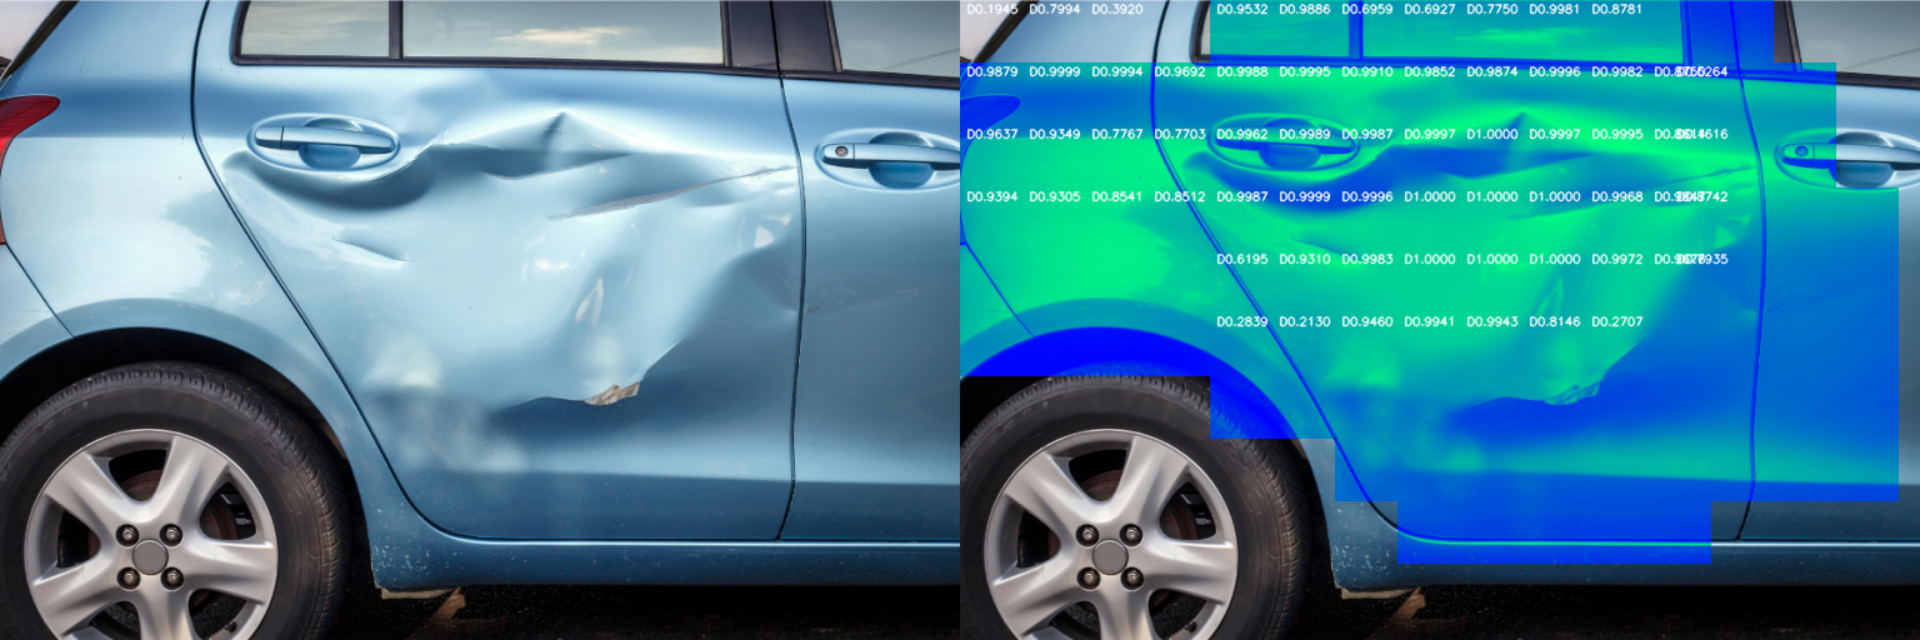

test_image_3.png


In [ ]:
#@markdown result
# import images
imgs = os.listdir(DATA_PATH)
imgs.sort()

for i in imgs:
  img = cv2.imread(os.path.join(DATA_PATH, i))
  height, width, channels = img.shape

  if MODEL_DETECTION:
    # detect orienttaion
    o, orien, prob_o, cid_o, x = detect_orientation(img, ANGLE_FRONT_MAX, ANGLE_SIDE_MAX, MODEL_ORIEN, DICT_OREN)

    # detect vehicle model
    mfr, veh, prob_v, cid_v, x = detect_vehicle(img, orien, MODEL_VEH, DICT_VEH)

    # generate heat map
    img_hm = generate_heatmap(MODEL_VEH[mfr][orien], x, cid_v, 'top_activation')
    img_veh = merge_with_heatmap(img[..., ::-1], img_hm)

  if DAMAGE_DETECTION:
    # detect damage
    damage, probs, coords = detect_damage(img, width, height, PATCH_SIZE, STEP_SIZE, DENT_THLD, SCRATCH_THLD, MODEL_DMG)
    
    # add overlay
    img_dmg = damage_overlay(img, damage, coords)

    # add text
    if SHOW_PROB:
      for j, c in enumerate(coords):
        x0, x1, y0, y1 = c[0][0], c[1][0], c[0][1], c[1][1]
        patch = img_dmg[y0:y1, x0:x1]

        if probs[j][1] > 0.1:
          text_overlay(patch, 5, 10, "D", probs[j][1], STEP_SIZE)
        if probs[j][2] > 0.1:
          text_overlay(patch, 5, 25, "S", probs[j][2], STEP_SIZE)
  
  # combine results
  if DAMAGE_DETECTION and MODEL_DETECTION:
    img_comb = cv2.hconcat([img_veh, img_dmg])
  elif MODEL_DETECTION:
    img_comb = cv2.hconcat([img, img_veh])
  elif DAMAGE_DETECTION:
    img_comb = cv2.hconcat([img, img_dmg])
  
  # scale output image
  scale = float(1920)/(width*2);
  img_final = cv2.resize(img_comb, dsize=(0, 0), fx=scale, fy=scale, interpolation=cv2.INTER_LINEAR)
  
  # print result
  cv2_imshow(img_final)
  print(i)
  if MODEL_DETECTION:
    print(mfr, orien, veh, prob_v)
